# Classical Shadow Transformer

## Initialization


ADD, COMMIT, PUSH

In [9]:
%run 'CST.py'
import matplotlib.pyplot as plt
import pickle
device = torch.device('cpu') # 'cpu', 'cuda', 'mps' ...

## Testing

### Transformer

#### Test 1: Log Probability Estimation

**Goal:** show that the log probability accumulated at sampling is the same as log probability evaluated by the model directly.

Create a model and put into evaluation mode (to disable dropout).

In [10]:
tf = Transformer(outtk_size=2)
tf.eval()
x = torch.tensor([[4],[4],[5],[5],[6],[6]])

In [11]:
y, logprob = tf.sample(x, 1, need_logprob=True)
y, logprob

(tensor([[2],
         [1],
         [1],
         [1],
         [1],
         [2]]),
 tensor([-0.5793, -0.8216, -0.7480, -0.7480, -1.0238, -0.4451]))

In [12]:
tf.logprob(x, y)

tensor([-0.5793, -0.8216, -0.7480, -0.7480, -1.0238, -0.4451],
       grad_fn=<SumBackward1>)

Results are matched up.

#### Test 2: Generative Modeling

**Goal:** test the ability of the transformer model to learn sequence-to-sequence map.

In [13]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])

In [14]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

In [15]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss = -tf.logprob(x, y).mean()
    loss.backward()
    optimizer.step()
    print('{:3d}: {:8.5g}'.format(epoch, loss.item()))

  0:  0.83488
  1:  0.64065
  2:  0.61779
  3:   0.6262
  4:  0.58149
  5:    0.541
  6:  0.51471
  7:  0.50461
  8:  0.49877
  9:  0.50706


Learns to predict $y$ from $x$.

In [16]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.967829167842865,
 0.032170817255973816,
 0.6482669115066528,
 0.3517330586910248,
 0.37630075216293335,
 0.6236993074417114,
 0.6236992478370667]

#### Test 3: VAE loss

**Goal**: test training the transformer with VAE bottleneck

In [17]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])

In [18]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

In [19]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss, logprob, kld = tf.loss(x, y, beta=0.)
    loss.backward()
    optimizer.step()
    print(f'{epoch:3d}: {loss.item():8.5g} {logprob.item():8.5g} {kld.item():8.5g}')

  0:  0.78347 -0.78347     1.26
  1:  0.63716 -0.63716   1.2685
  2:   0.5901  -0.5901   1.2734
  3:  0.53979 -0.53979   1.2854
  4:  0.56423 -0.56423   1.2714
  5:  0.54145 -0.54145   1.2672
  6:  0.51828 -0.51828   1.2819
  7:  0.46711 -0.46711   1.2853
  8:  0.51398 -0.51398   1.3073
  9:  0.47194 -0.47194   1.3208


Learns to predict $y$ from $x$.

In [21]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9753502607345581,
 0.024649787694215775,
 0.48954498767852783,
 0.5104550719261169,
 0.2665882110595703,
 0.7334117889404297,
 0.7334117889404297]

Now the accuracy can be controlled by the hyperparameter $\beta$.

#### Test 4: Sampling

**Goal**: test sampling and completion.

In [22]:
tf = Transformer(outtk_size=2)
x = torch.randint(4,7,(3,5))
tf.sample(x)

tensor([[2, 2, 2, 2],
        [2, 2, 1, 2],
        [2, 1, 1, 2]])

Completion task.

In [23]:
y = torch.randint(1,3,(3,2))
y

tensor([[2, 2],
        [2, 2],
        [2, 1]])

In [24]:
tf.sample(x, tgt_seq=y)

tensor([[2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 1, 2, 1]])

### Operator

#### Test 1: Operator Algebra

**Goal:** test operator algebra are correct

In [25]:
ops = [pauli([i]) for i in range(4)]
ops

[I, X, Y, Z]

Multiplication table of Pauli operators

In [26]:
for op1 in ops: 
    for op2 in ops:
        print(f'{op1} @ {op2} = {op1 @ op2}')

I @ I = I
I @ X = X
I @ Y = Y
I @ Z = Z
X @ I = X
X @ X = I
X @ Y = i Z
X @ Z = -i Y
Y @ I = Y
Y @ X = -i Z
Y @ Y = I
Y @ Z = i X
Z @ I = Z
Z @ X = i Y
Z @ Y = -i X
Z @ Z = I


#### Test 2: Operator Gradient

Example: construct an operator

In [27]:
O = pauli('X') + 1j * pauli('Y') - 2 * pauli('Z')
O

X + i Y -2 Z

In [28]:
O = O.requires_grad_()
O

X + i Y -2 Z (requires_grad=True)

In [29]:
O.H @ O

6 I -4 X -2 Z (grad_fn=<class 'IndexBackward0'>)

Operator norm is defined to be $\Vert O\Vert^2=\mathrm{Tr}\,O^\dagger O$

In [30]:
O.norm()

tensor(6., grad_fn=<SelectBackward0>)

In [31]:
O.norm().backward()
O.grad

2 X + (0.00+2.00i) Y -4 Z

### Shadow

#### Test 1: Shadow Evaluate 

**Goal:** evaluate operator expectation value on a shadow dataset.

In [37]:
shd= ghz_shadow(3, 1000)
shd

| -X +Y +Y |
| -Y +Z +Z |
| -Z -Z +X |
| -Y -Z +X |
| +Y -X +Y |
| +Y +Y -Z |
| -X -Z +Y |
| -X -Y +Z |
| -Z -X -Z |
| -Z +X -Z |
| -Y +X +Z |
| -X +X -X |
| -Z -Z -Y |
| -Y +X +Y |
| +Y +Y -Z |
| -X -Y +X |
...

In [38]:
pauli('ZZI').expectation(shd)

tensor(0.9450+0.j)

### ClassicalShadowTransformer

#### Test 1: Sampling

**Goal**: test sampling and state reconstruction

In [39]:
cst = ClassicalShadowTransformer(2,0)
cst.sample(6)

| +Z -Y |
| +Y -Z |
| -Y -Z |
| -X -Y |
| +Y +X |
| -Z -Z |

Reconstruct density operator (matrix).

In [40]:
rho = cst.rho()
rho

1.00 II -0.44 IX -0.49 IY -0.52 IZ -0.27 XI + 0.35 XX + 0.36 XY + 0.40 XZ -0.30 YI + 0.37 YX + 0.37 YY + 0.36 YZ -0.36 ZI + 0.40 ZX + 0.37 ZY + 0.42 ZZ (grad_fn=<class 'SqueezeBackward4'>)

In [41]:
rhomat = rho.matrix_form() / 2**2
rhomat

tensor([[ 0.1372+0.0000j, -0.0089+0.0301j,  0.0312-0.0153j, -0.0043-0.1836j],
        [-0.0089-0.0301j,  0.1851+0.0000j,  0.1797-0.0038j, -0.1667+0.1631j],
        [ 0.0312+0.0153j,  0.1797+0.0038j,  0.1037+0.0000j, -0.2087+0.2164j],
        [-0.0043+0.1836j, -0.1667-0.1631j, -0.2087-0.2164j,  0.5739+0.0000j]],
       grad_fn=<DivBackward0>)

In [42]:
torch.linalg.eigvalsh(rhomat)

tensor([-0.1097,  0.0404,  0.1927,  0.8766], grad_fn=<LinalgEighBackward0>)

#### Test 2: Evaluation

**Goal**: test logprob and loss function evaluation.

In [43]:
cst = ClassicalShadowTransformer(2,0)
cst.eval()
shd = ghz_shadow(2,10)

In [44]:
cst.logprob(shd)

tensor([-1.8768, -1.2028, -0.8698, -2.3538, -1.0704, -1.0704, -0.9098, -0.7516,
        -2.3681, -0.7461], grad_fn=<SumBackward1>)

In [45]:
cst.loss(shd)

(tensor(2.4953, grad_fn=<MeanBackward0>),
 tensor(-1.2599, grad_fn=<MeanBackward0>),
 tensor(1.2355, grad_fn=<MeanBackward0>))

## Training

### Batch Training

Scaning over parameter space and train a collection of models of different number of qubits and hyperparameter $\beta$. `max_steps` - maximal optimization step, `nsr` - the noise signal ratio threshold for the loss function flucturation (optimization stop when the noise signal ratio is larger than this threshold), `window` - the window size used to estimate noise signal ratio (larger window size stricter convergence criterion), `n_sample` - number of classical shadow samples used in each iteration, `lr` -  learning rate.

In [46]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).to(device).load()
        cst.optimize(10000, max_steps=30000, nsr=32, window=400, n_sample=1000, lr=0.0001)
        


./model/CST_d64_h16_l1/GHZ_N1_b-2
2346:  0.45879 -0.45005  0.03495 -0.06333


KeyboardInterrupt: 

Inspect loss history to determine convergence.

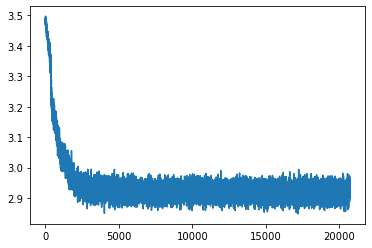

In [47]:
cst = ClassicalShadowTransformer(5,-4).load()
#print(cst.transformer.repara.logvar)
plt.plot(cst.loss_history[100:])

### Fine Tuning

If necessary, a model can be loaded for fine tuning with smaller training rate to ensure convergence.

In [48]:
cst = ClassicalShadowTransformer(5, -6).load()

In [49]:
cst.optimize(1000, max_steps=10000, nsr=32, window=1000, n_sample=1000, lr=0.00001)

./model/CST_d64_h16_l1/GHZ_N5_b-6
 44:  2.86885 -2.86637  0.15846 -0.35466


KeyboardInterrupt: 

## Evaluation

### Loss Function History

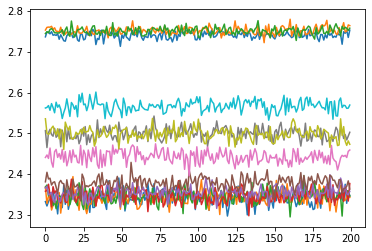

In [50]:
for logbeta in range(-6,7):
    cst = ClassicalShadowTransformer(4,logbeta).load()
    plt.plot(cst.loss_history[-200:])

### Fidelity and Entropy Map

Compute fidelity and entropy (in unit of bit) of the reconstructed density matrix.

In [51]:
data = []
for n_qubit in range(1, 6):
    for logbeta in range(-6, 7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form()/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid = (rho[0,0] + rho[-1,-1] + rho[0,-1] + rho[-1,0])/2
        fid = fid.real.item()
        vals = torch.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -torch.log2(vals).dot(vals).item()
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, logbeta, fid, ent])

./model/CST_d64_h16_l1/GHZ_N5_b3
F = 0.4973459541797638, S = 1.5282715559005737


KeyboardInterrupt: 

In [52]:
with open('./data/map.dat', 'wb') as f:
    pickle.dump(data, f)

Fidelity for 6 qubits (and beyond) can only be estimated by classical shadow tomography. First, prepare the GHZ state density matrix and convert it to Operator class.

In [53]:
rho = qst.ghz_state(6).density_matrix
tok = rho.tokenize()
paulis = tok[:,:-1]
coeffs = (9.-2.*tok[:,-1]) * rho.cs
rho = Operator(torch.tensor(paulis), torch.tensor(coeffs))

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Then evaluate the expectation value of the density matrix on the classical shadow ensemble.

In [33]:
#data = []
for logbeta in range(2, 7):
    cst = ClassicalShadowTransformer(6, logbeta, embed_dim=128, n_layers=2).load().eval();
    clear_output(wait=True)
    print(cst.path + '/' + cst.file)
    fids = []
    for _ in range(5):
        shd = cst.sample(100000)
        fid = rho.expectation(shd, batch_size=1000).real.item()
        print(f'F = {fid:8.5f}')
        fids.append(fid)
    data.append([6, logbeta, fids])

./model/CST_d128_h16_l2/GHZ_N6_b6
F =  0.08763
F =  0.06920
F =  0.06147
F =  0.07483
F =  0.07469


In [35]:
with open('./data/fid6_d128_l2.dat', 'wb') as f:
    pickle.dump(data, f)

### Atlas Boreas Cygnus

Take three representative models.

In [44]:
mdls = {
    'atlas': ClassicalShadowTransformer(5, -5).load().eval(),
    'boreas': ClassicalShadowTransformer(5, -1).load().eval(),
    'cygnus': ClassicalShadowTransformer(5, 6).load().eval()}

Chat with the model. Dictionary:

| Number | Symbol |
|--------|--------|
| `1`    | `+`    |
| `2`    | `-`    |
| `3`    | `I`    |
| `4`    | `X`    |
| `5`    | `Y`    |
| `6`    | `Z`    |

* Z-test: `x: ZZZZZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* X-test: `x: XXXXX, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* XZ-test: `x: XXXXZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 

Collect data:

In [61]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/z_test.dat', 'wb') as f:
    pickle.dump(data, f)

In [62]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/x_test.dat', 'wb') as f:
    pickle.dump(data, f)

In [63]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
x[:,-1] = 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/xz_test.dat', 'wb') as f:
    pickle.dump(data, f)

### Density Matrix Reconstruction

Reconstruct density matrices for representative models.

In [65]:
data = {}
for name, mdl in mdls.items():
    with torch.no_grad():
        rho = mdl.rho().matrix_form()/2**mdl.n_qubit # reconstruction
    data[name] = rho.tolist()
with open('./data/rhos.dat', 'wb') as f:
    pickle.dump(data, f)

### Latent Space Structure

In [92]:
from sklearn.manifold import TSNE
tsne = TSNE(2)
x = torch.cartesian_prod(*[torch.tensor([4,5,6])]*5)
data = {'x': (x-3).tolist()}
for name, mdl in mdls.items():
    with torch.no_grad():
        src = mdl.transformer.embed(x)
        mem = mdl.transformer.encode(src)
    mem = mem.view(mem.shape[0],-1)
    z = tsne.fit_transform(mem)
    data[name] = z.tolist()
with open('./data/z_embed.dat', 'wb') as f:
    pickle.dump(data, f)